# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
# YOUR CODE HERE!
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [5]:
# Fetch current BTC price
btc_response = requests.get(btc_url)
btc_data = btc_response.json()
btc_price = btc_data['data']['1']['quotes']['USD']['price']

# Fetch current ETH price
eth_response = requests.get(eth_url)
eth_data = eth_response.json()
eth_price = eth_data['data']['1027']['quotes']['USD']['price']

# Compute current value of my crpto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $48225.60
The current value of your 5.3 ETH is $16078.08


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [7]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [8]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
  alpaca_api_key,
  alpaca_secret_key,
  api_version="v2"
)

In [9]:
# Format current date as ISO format
today = pd.Timestamp("2022-04-12", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
my_portfolio = alpaca.get_bars(
  tickers,
  timeframe,
  start = today,
  end = today
).df

# Reorganize the DataFrame
# Separate ticker data
AGG = my_portfolio[my_portfolio['symbol']=='AGG'].drop('symbol', axis=1)
SPY = my_portfolio[my_portfolio['symbol']=='SPY'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
portfolio = pd.concat([AGG, SPY], axis=1, keys=['AGG', 'SPY'])

# Preview DataFrame
portfolio

AGG                                   \
                             open    high     low   close   volume   
timestamp                                                            
2022-04-12 04:00:00+00:00  104.83  104.92  104.58  104.61  8448652   

                                                      SPY                    \
                          trade_count        vwap    open    high       low   
timestamp                                                                     
2022-04-12 04:00:00+00:00       29955  104.740856  443.02  445.75  436.6501   

                                                                     
                            close    volume trade_count        vwap  
timestamp                                                            
2022-04-12 04:00:00+00:00  438.29  84020734      694115  440.815476

In [10]:
# Pick AGG and SPY close prices
agg_close_price = float(portfolio['AGG']['close'])
spy_close_price = float(portfolio['SPY']['close'])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $104.61
Current SPY closing price: $438.29


In [11]:
# Compute the current value of shares
my_agg_value = agg_close_price * my_agg
my_spy_value = spy_close_price * my_spy

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $21914.50
The current value of your 200 AGG shares is $20922.00


### Savings Health Analysis

In [12]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
fin_assets = {
  'amount': [(my_btc_value+my_eth_value),(my_agg_value+my_spy_value)]
}

index = ['crypto','shares']

# Create savings DataFrame
df_savings = pd.DataFrame(fin_assets, index=index)

# Display savings DataFrame
display(df_savings)

,amount
crypto,64303.68
shares,42836.50


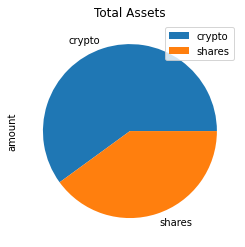

In [13]:
# Plot savings pie chart
df_savings.plot.pie(y='amount', legend=True, title='Total Assets');

In [14]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings['amount']['crypto'] + df_savings['amount']['shares']

# Validate saving health
if total_savings > emergency_fund:
  print(f"Congratulations, you have more than enough savings for an emergency fund.")
elif total_savings < emergency_fund:
  print(f"I'm sorry, but you do not have enough savings for an emergency fund.")
else: 
  print(f"You have just enough savings for an emergency fund.")

Congratulations, you have more than enough savings for an emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [15]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen

end_date = (pd.Timestamp.today(tz='America/New_York') - pd.DateOffset()).isoformat()
start_date = (pd.Timestamp.today(tz='America/New_York') - pd.DateOffset(years=5)).isoformat()

In [23]:
# Get 5 years' worth of historical data for SPY and AGG
df_ticker = alpaca.get_bars(
  tickers,
  timeframe,
  start=start_date,
  end=end_date
).df

# Reorganize the DataFrame
# Separate ticker data
AGG = df_ticker[df_ticker['symbol'] =='AGG'].drop('symbol', axis=1)
SPY = df_ticker[df_ticker['symbol'] =='SPY'].drop('symbol', axis=1)


# Concatenate the ticker DataFrames
df_stock_data = pd.concat([AGG,SPY], axis=1, keys=['AGG','SPY'])

# Display sample data
df_stock_data.head()

AGG                                     \
                             open      high     low   close   volume   
timestamp                                                              
2017-04-17 04:00:00+00:00  109.30  109.4000  109.18  109.21  1646056   
2017-04-18 04:00:00+00:00  109.41  109.7000  109.39  109.65  2369862   
2017-04-19 04:00:00+00:00  109.47  109.5600  109.39  109.48  2148531   
2017-04-20 04:00:00+00:00  109.31  109.4000  109.20  109.31  1867805   
2017-04-21 04:00:00+00:00  109.40  109.4899  109.30  109.34  1539265   

                                                      SPY                   \
                          trade_count        vwap    open     high     low   
timestamp                                                                    
2017-04-17 04:00:00+00:00        7973  109.294030  233.12  234.570  232.88   
2017-04-18 04:00:00+00:00       14488  109.579396  233.71  234.490  233.08   
2017-04-19 04:00:00+00:00        9587  109.455386  234.52  234.950  233.18   
2017-04-20 04:00:00+00:00        7319  109.301387  234.14  235.845  233.78   
2017-04-21 04:00:00+00:00        8708  109.386803  235.22  235.310  234.13   

                                                                      
                            close     volume trade_count        vwap  
timestamp                                                             
2017-04-17 04:00:00+00:00  234.57   68405367      213643  233.870859  
2017-04-18 04:00:00+00:00  233.87   83225836      245279  233.958942  
2017-04-19 04:00:00+00:00  233.44   68699868      248643  233.953779  
2017-04-20 04:00:00+00:00  235.34   92572186      279885  234.978432  
2017-04-21 04:00:00+00:00  234.59  110389847      258915  234.784238

In [24]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirty_years = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [1/2, 1/2],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [25]:
# Printing the simulation input data
MC_thirty_years.portfolio_data.tail()

AGG                                     \
                             open     high      low   close   volume   
timestamp                                                              
2022-04-08 04:00:00+00:00  104.82  105.010  104.615  104.73  6501822   
2022-04-11 04:00:00+00:00  104.44  104.505  104.170  104.28  8377902   
2022-04-12 04:00:00+00:00  104.83  104.920  104.580  104.61  8448652   
2022-04-13 04:00:00+00:00  104.77  105.090  104.740  104.82  6868550   
2022-04-14 04:00:00+00:00  104.73  104.740  103.930  103.97  8505987   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2022-04-08 04:00:00+00:00       24900  104.804999    -0.005035  448.04   
2022-04-11 04:00:00+00:00       29767  104.312835    -0.004297  444.11   
2022-04-12 04:00:00+00:00       29955  104.740856     0.003165  443.02   
2022-04-13 04:00:00+00:00       27348  104.889799     0.002007  437.96   
2022-04-14 04:00:00+00:00       30443  104.171733    -0.008109  443.44   

                                                                             \
                               high       low   close    volume trade_count   
timestamp                                                                     
2022-04-08 04:00:00+00:00  450.6300  445.9400  447.57  79148376      573491   
2022-04-11 04:00:00+00:00  445.0000  439.3900  439.92  89825549      779421   
2022-04-12 04:00:00+00:00  445.7500  436.6501  438.29  84020734      694115   
2022-04-13 04:00:00+00:00  444.1100  437.8400  443.31  73734315      563285   
2022-04-14 04:00:00+00:00  444.7301  437.6800  437.79  98667135      703727   

                                                    
                                 vwap daily_return  
timestamp                                           
2022-04-08 04:00:00+00:00  448.250805    -0.002674  
2022-04-11 04:00:00+00:00  442.206374    -0.017092  
2022-04-12 04:00:00+00:00  440.815476    -0.003705  
2022-04-13 04:00:00+00:00  441.262058     0.011454  
2022-04-14 04:00:00+00:00  440.305786    -0.012452

In [26]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirty_years.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


c:\Users\emers\finTech\Rutgers_FinTech_Homework\Week-Five-Homework\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.996495,1.013570,0.999478,1.002382,0.995836,0.996554,0.990719,1.001808,0.996207,1.005623,...,1.001318,1.001660,1.000104,1.003422,1.005526,1.005602,0.995637,1.004657,0.996391,1.008198
2,0.998082,1.017161,1.001138,1.009566,0.996587,1.001573,0.993487,1.003503,0.981622,1.006069,...,0.998989,1.000365,1.002152,1.004176,1.010632,0.996225,0.994102,1.003962,1.006604,1.010220
3,0.995583,1.007592,0.998681,1.002408,0.996083,1.001102,0.994895,1.010793,0.981410,1.000461,...,1.011226,1.002222,1.006977,1.009255,1.021427,0.987929,1.003766,1.009430,1.008013,1.015007
4,1.005842,0.999718,1.001082,1.012585,0.998942,0.993727,0.994719,1.008733,0.972421,1.014710,...,1.021864,0.999302,1.019954,1.018370,1.007728,0.978131,0.997348,1.011522,1.008480,1.023072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,10.624260,2.347034,2.256792,4.444369,13.248797,9.883541,5.535897,15.031265,4.050436,4.687296,...,6.063477,5.912703,27.778599,6.948133,8.856731,3.055891,3.779653,7.235091,4.239777,4.174839
7557,10.547553,2.327868,2.269928,4.453396,13.263925,9.946815,5.499721,15.114117,4.050578,4.666672,...,6.076088,5.958318,27.752676,6.917897,8.748569,3.098601,3.755593,7.178870,4.220545,4.207667
7558,10.584484,2.328748,2.262881,4.454693,13.446861,9.923192,5.489222,15.167690,4.050337,4.649941,...,6.126823,5.945374,27.705219,6.864448,8.762956,3.116117,3.773524,7.183513,4.230354,4.220645
7559,10.499146,2.346752,2.248536,4.419972,13.428358,9.947245,5.484244,15.265571,4.035499,4.670990,...,6.127656,5.980161,27.788193,6.882276,8.704187,3.095467,3.770687,7.215101,4.253777,4.243161


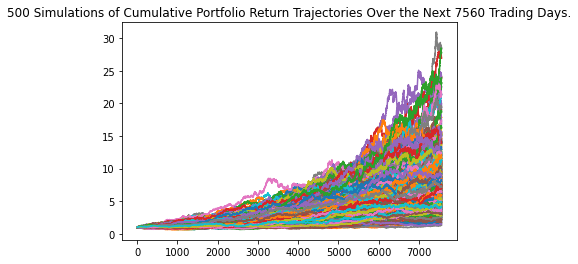

In [27]:
# Plot simulation outcomes
MC_returns_plot = MC_thirty_years.plot_simulation()
MC_returns_plot.get_figure().savefig('30_Years_Return.png', bbox_inches='tight')

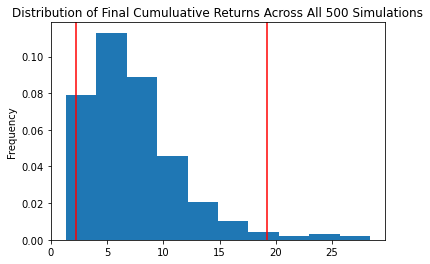

In [29]:
# Plot probability distribution and confidence intervals
prob_dist_plot = MC_thirty_years.plot_distribution()
prob_dist_plot.get_figure().savefig('MC_thirty_years_dist_plot.png', bbox_inches='tight')

### Retirement Analysis

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

count           500.000000
mean             22.130012
std              16.088798
min               2.342293
25%              10.465170
50%              17.476764
75%              29.550007
max             104.663919
95% CI Lower      4.779747
95% CI Upper     64.053604
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [ ]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $95594.94 and $1281072.08


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [ ]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $143392.41 and $1921608.12


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [ ]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
# YOUR CODE HERE!

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001799,1.000245,1.006243,0.995742,1.003219,0.998395,0.997985,1.004253,1.002497,0.998947,...,1.007121,1.004291,1.000334,1.000876,0.998973,1.001375,0.996477,1.002103,1.005063,0.995521
2,0.998289,1.000243,1.004284,0.996554,1.004502,0.993317,0.996037,1.010316,1.000850,0.996382,...,1.007016,1.003709,0.999542,1.001450,1.004142,1.004022,0.996702,1.004359,1.009205,0.999000
3,1.002639,0.997279,1.008339,0.992870,0.998657,0.989041,0.994189,1.010062,0.999200,0.999132,...,1.004156,1.002288,1.003976,0.994908,1.008989,1.004545,0.995074,1.010488,1.011124,1.002626
4,1.008853,0.996292,1.002813,0.995244,0.996794,0.990576,0.999322,1.010897,0.989222,0.995257,...,1.000057,1.007349,1.006909,0.990823,1.013085,1.002427,0.996293,1.007081,1.010369,0.998654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.438618,0.926659,1.048662,1.101424,1.134443,1.200987,1.347489,1.257520,1.428939,1.194429,...,1.104654,1.273680,1.276718,1.297344,1.229379,1.295593,1.501864,1.198438,1.386161,1.426163
1257,1.441785,0.926428,1.048574,1.104941,1.137374,1.204559,1.360843,1.260661,1.429710,1.201055,...,1.107447,1.269262,1.265880,1.296800,1.227049,1.297884,1.510874,1.190802,1.388448,1.427391
1258,1.444675,0.931714,1.053040,1.110206,1.140592,1.199869,1.358605,1.254728,1.426409,1.207420,...,1.101690,1.274683,1.281527,1.303255,1.227517,1.294870,1.503567,1.191945,1.388434,1.441467
1259,1.443488,0.934065,1.049921,1.108998,1.142538,1.203844,1.363563,1.254192,1.425030,1.213366,...,1.103902,1.276629,1.275813,1.296929,1.222773,1.285521,1.498580,1.192940,1.397786,1.440244


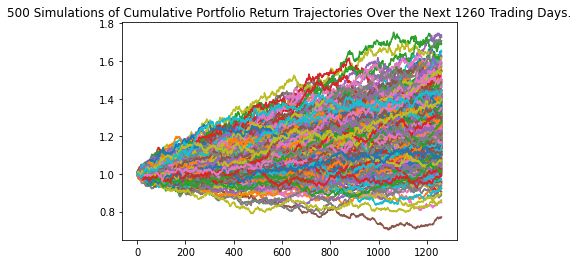

In [ ]:
# Plot simulation outcomes
# YOUR CODE HERE!

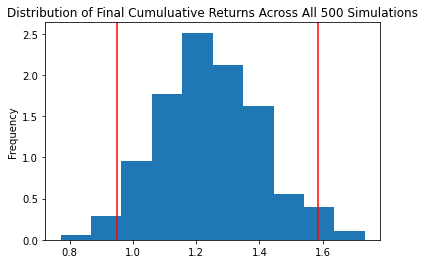

In [ ]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

count           500.000000
mean              1.245905
std               0.160008
min               0.771559
25%               1.140795
50%               1.232555
75%               1.352284
max               1.733421
95% CI Lower      0.951523
95% CI Upper      1.586592
Name: 1260, dtype: float64


In [ ]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $57091.37 and $95195.55


### Ten Years Retirement Option

In [ ]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.004461,1.003269,0.998934,0.996767,1.000906,0.999279,0.995262,1.005752,0.993466,0.993655,...,1.001427,1.004350,0.996932,0.996844,0.997507,1.003457,0.998736,1.001195,0.999904,1.010218
2,1.007901,1.003304,0.993812,0.999973,1.000910,1.002347,0.996311,1.007234,0.993550,0.991021,...,0.997379,1.001952,0.998124,0.998063,1.001733,1.000273,0.994865,1.000109,0.994648,1.007838
3,1.007532,1.001077,0.990963,0.998339,1.001779,1.003653,0.994439,1.012230,0.999170,0.996484,...,0.995265,1.001745,0.995332,1.003023,1.003800,0.999755,0.997616,1.004730,0.993391,1.010444
4,1.020339,1.005743,0.991869,0.998218,1.005630,1.008717,0.987764,1.012750,0.999227,0.996474,...,0.999028,1.004730,0.995357,1.000204,1.008738,0.999273,0.999426,1.003776,0.991478,1.013379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.616922,1.761703,1.143430,1.687801,1.743826,1.174891,1.514199,2.447129,1.589765,1.570578,...,1.316494,1.863650,1.727959,1.411033,1.804671,1.500605,1.413278,1.552375,1.318340,1.960015
2517,1.620285,1.769184,1.145132,1.695693,1.742878,1.175745,1.517697,2.441471,1.586174,1.560826,...,1.318463,1.857860,1.724003,1.409092,1.810136,1.499466,1.413210,1.552539,1.316872,1.956776
2518,1.622141,1.771927,1.149019,1.691589,1.739420,1.178965,1.522624,2.444413,1.580680,1.566154,...,1.317147,1.864694,1.727503,1.419561,1.821212,1.492831,1.412283,1.556659,1.318842,1.961271
2519,1.628885,1.770207,1.149670,1.703935,1.738053,1.182429,1.519485,2.441360,1.565663,1.576607,...,1.307985,1.858986,1.728039,1.430017,1.814690,1.496851,1.409284,1.562660,1.324798,1.964190


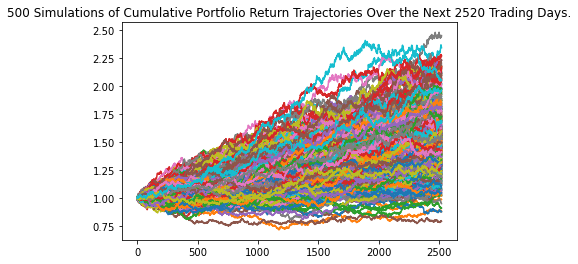

In [ ]:
# Plot simulation outcomes
# YOUR CODE HERE!

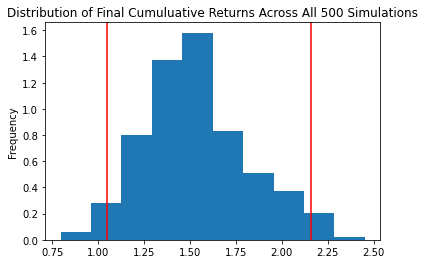

In [ ]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

count           500.000000
mean              1.537014
std               0.282192
min               0.795263
25%               1.339641
50%               1.523799
75%               1.693927
max               2.451787
95% CI Lower      1.049781
95% CI Upper      2.159935
Name: 2520, dtype: float64


In [ ]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $62986.85 and $129596.12
